In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [2]:
df = pd.read_csv("data.csv")
df.head()

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330


In [3]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [4]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(16)
        )
        self.mu = nn.Linear(16, latent_dim)
        self.log_var = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(16),
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.Linear(32, input_dim)
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        enc = self.encoder(x)
        mu, log_var = self.mu(enc), self.log_var(enc)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

Epoch 0, Loss: 1.4763
Epoch 10, Loss: 1.1126
Epoch 20, Loss: 0.9889
Epoch 30, Loss: 0.9501
Epoch 40, Loss: 0.9186
Epoch 50, Loss: 0.8902
Epoch 60, Loss: 0.8457
Epoch 70, Loss: 0.8310
Epoch 80, Loss: 0.8035
Epoch 90, Loss: 0.7545
Epoch 99, Loss: 0.7268
Epoch 0, Loss: 1.5104
Epoch 10, Loss: 1.1711
Epoch 20, Loss: 1.0509
Epoch 30, Loss: 0.9543
Epoch 40, Loss: 0.8988
Epoch 50, Loss: 0.8273
Epoch 60, Loss: 0.7856
Epoch 70, Loss: 0.7635
Epoch 80, Loss: 0.7196
Epoch 90, Loss: 0.7047
Epoch 99, Loss: 0.6766
Epoch 0, Loss: 2.8415
Epoch 10, Loss: 1.1193
Epoch 20, Loss: 1.0157
Epoch 30, Loss: 0.9810
Epoch 40, Loss: 0.9376
Epoch 50, Loss: 0.8586
Epoch 60, Loss: 0.8311
Epoch 70, Loss: 0.8158
Epoch 80, Loss: 0.7604
Epoch 90, Loss: 0.7375
Epoch 99, Loss: 0.7059
Epoch 0, Loss: 1.3926
Epoch 10, Loss: 1.0792
Epoch 20, Loss: 0.9448
Epoch 30, Loss: 0.8676
Epoch 40, Loss: 0.8163
Epoch 50, Loss: 0.7613
Epoch 60, Loss: 0.7215
Epoch 70, Loss: 0.6796
Epoch 80, Loss: 0.6582
Epoch 90, Loss: 0.6361
Epoch 99, Loss:

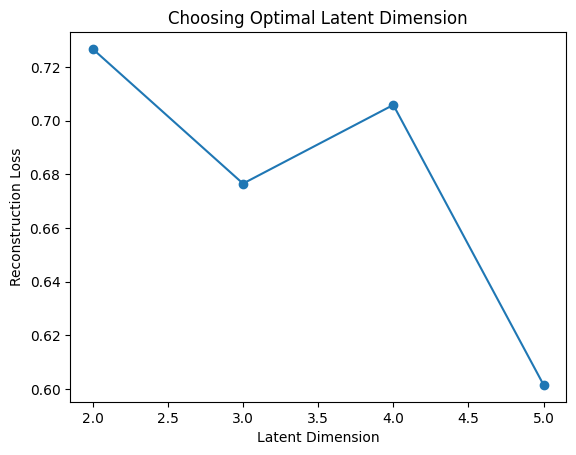

In [5]:
latent_dims = [2, 3, 4, 5]  
reconstruction_losses = []

for latent_dim in latent_dims:
    vae = VAE(input_dim=data_scaled.shape[1], latent_dim=latent_dim)  
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    # optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    # loss_fn = nn.SmoothL1Loss()

    for epoch in range(100):  
        x = torch.tensor(data_scaled, dtype=torch.float32)
        optimizer.zero_grad()
        x_recon, mu, log_var = vae(x)
        recon_loss = loss_fn(x_recon, x)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + 0.1 * kl_loss
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch==99:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    reconstruction_losses.append(loss.item())

plt.plot(latent_dims, reconstruction_losses, marker='o', linestyle='-')
plt.xlabel("Latent Dimension")
plt.ylabel("Reconstruction Loss")
plt.title("Choosing Optimal Latent Dimension")
plt.show()


In [6]:
# Training VAE
input_dim = data_scaled.shape[1]
latent_dim = 4  # From checking, I got 4 to be the better latent dimension.
vae = VAE(input_dim, latent_dim)
# optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
# loss_fn = nn.SmoothL1Loss()
loss_fn = nn.MSELoss()

In [7]:
def train_vae(epochs=100):
    vae.train()
    for epoch in range(epochs):
        x = torch.tensor(data_scaled, dtype=torch.float32)
        optimizer.zero_grad()
        x_recon, mu, log_var = vae(x)
        recon_loss = loss_fn(x_recon, x)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + 0.1 * kl_loss 
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == 99:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [8]:
train_vae()

Epoch 0, Loss: 1.3984
Epoch 10, Loss: 1.0609
Epoch 20, Loss: 0.9288
Epoch 30, Loss: 0.8532
Epoch 40, Loss: 0.8064
Epoch 50, Loss: 0.7554
Epoch 60, Loss: 0.7077
Epoch 70, Loss: 0.6682
Epoch 80, Loss: 0.6353
Epoch 90, Loss: 0.6064
Epoch 99, Loss: 0.5795


In [9]:
# Get Latent Representations
vae.eval()
x = torch.tensor(data_scaled, dtype=torch.float32)
_, mu, _ = vae(x)
latent_data = mu.detach().numpy()

In [10]:
# Elbow Method to Determine k
from kneed import KneeLocator

inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(latent_data)
    inertia.append(kmeans.inertia_)

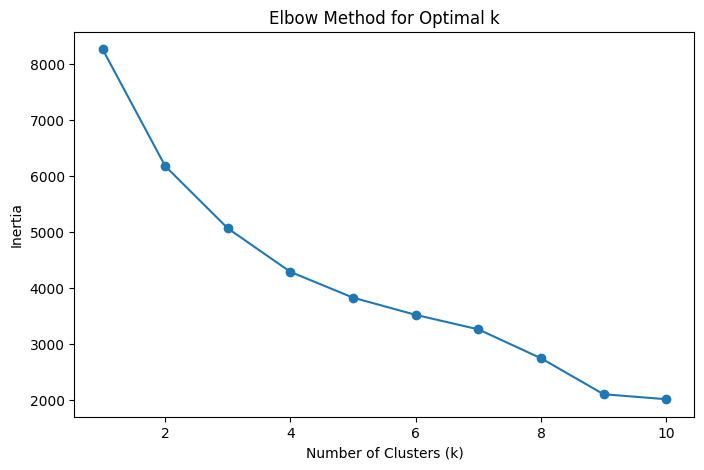

Optimal k found: 4


In [11]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow
print(f"Optimal k found: {optimal_k}")

In [12]:
# Apply K-Means
optimal_k = 3  # From above checking, I got 3 to be the better number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(latent_data)
labels = kmeans.labels_